In [1]:
'''Train an encoder using Contrastive Learning.'''
import argparse
import os
import subprocess

import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim as optim
from torchlars import LARS
from tqdm import tqdm

from configs import get_datasets
from critic import LinearCritic
from evaluate import save_checkpoint,save_checkpoint2, encode_train_set, train_clf, test, update_checkpoint
from models import *
from scheduler import CosineAnnealingWithLinearRampLR
from augmentation import ManualNormalise, DifferentiableColourDistortionByTorch_manual, gen_lambda
from torchvision import transforms

import torch.autograd as autograd

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import torch
import numbers
import random
from torch import Tensor
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

In [4]:
# config
### config ####
num_workers = 16
batch_size = 512
img_size = 32
temperature = 0.5
dataset = 'cifar10'
CACHED_MEAN_STD = {
        'cifar10': ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        'cifar100': ((0.5071, 0.4865, 0.4409), (0.2009, 0.1984, 0.2023)),
        'stl10': ((0.4409, 0.4279, 0.3868), (0.2309, 0.2262, 0.2237)),
        'imagenet': ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    }

device = 'cuda' if torch.cuda.is_available() else 'cpu'
base_lr = 0.25
arch = 'resnet18'
momentum = 0.9
cosine_anneal = True
num_epochs = 1
test_freq = 1
resume = 'resnet18_aam_new_gp5_0_n1.pth99'
norm = 1
lambda_gp = 5

In [5]:
lr = base_lr * (batch_size / 256)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch
last_epoch = num_epochs #last epoch or from last epoch from checkpoint 
clf = None
current_checkpoint = {}
acc = 0

print('==> Preparing data..')
trainset, testset, clftrainset, num_classes, stem = get_datasets(dataset)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True,
                                          num_workers=num_workers, pin_memory=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=1000, shuffle=False, num_workers=num_workers,
                                         pin_memory=True)
clftrainloader = torch.utils.data.DataLoader(clftrainset, batch_size=1000, shuffle=False, num_workers=num_workers,
                                             pin_memory=True)

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


# Print dL/ d lambda

In [7]:
def cal_gradient_lambda_full(resume, norm, lambda_gp):
    # config
    ### config ####
    gradient_lambda_list = []

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    base_lr = 0.25
    arch = 'resnet18'
    momentum = 0.9
    cosine_anneal = True
    num_epochs = 1
    test_freq = 1
    lr = base_lr * (batch_size / 256)
    
    best_acc = 0  # best test accuracy
    start_epoch = 0  # start from epoch 0 or last checkpoint epoch
    last_epoch = num_epochs #last epoch or from last epoch from checkpoint 
    clf = None
    current_checkpoint = {}
    acc = 0
    # Model
    print('==> Building model..')
    ##############################################################
    # Encoder
    ##############################################################
    if arch == 'resnet18':
        net = ResNet18(stem=stem)
    elif arch == 'resnet34':
        net = ResNet34(stem=stem)
    elif arch == 'resnet50':
        net = ResNet50(stem=stem)
    else:
        raise ValueError("Bad architecture specification")
    net = net.to(device)

    ##############################################################
    # Critic
    ##############################################################
    critic = LinearCritic(net.representation_dim, temperature=temperature).to(device)

    ###### Differentiable augmentation ######
    brightness_bound = [0.2, 1.8]
    contrast_bound = [0.2, 1.8]
    saturation_bound = [0.2, 1.8]
    hue_bound = [-0.2, 0.2]

    if device == 'cuda':
        repr_dim = net.representation_dim
        net = torch.nn.DataParallel(net)
        net.representation_dim = repr_dim
        cudnn.benchmark = True

    criterion = nn.CrossEntropyLoss()
    base_optimizer = optim.SGD(list(net.parameters()) + list(critic.parameters()), lr=lr, weight_decay=1e-6,
                               momentum=momentum)
    if cosine_anneal == True:
        scheduler = CosineAnnealingWithLinearRampLR(base_optimizer, num_epochs)
    encoder_optimizer = LARS(base_optimizer, trust_coef=1e-3)

    #Resume
    if resume:
        # Load checkpoint.
        print('==> Resuming from checkpoint..')
        assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
        resume_from = os.path.join('./checkpoint', resume)
        checkpoint = torch.load(resume_from)
        net.load_state_dict(checkpoint['net'])
        critic.load_state_dict(checkpoint['critic'])
    #     best_acc = checkpoint['acc']
        start_epoch = checkpoint['epoch'] + 1
        encoder_optimizer.load_state_dict(checkpoint['encoder_optim'])
        base_optimizer.load_state_dict(checkpoint['base_optim'])
        scheduler.step(start_epoch)
        if 'num_epochs' in checkpoint:
            last_epoch = checkpoint['num_epochs']
        else:
            last_epoch = 1000 #default value for num epochs = 1000
        current_checkpoint = checkpoint
        ##### Train #####
        print('\nEpoch: %d' % start_epoch)
        net.train()
        critic.train()
        train_loss = 0
        sum_gradient = 0
        train_loss_nogp = 0
        t = tqdm(enumerate(trainloader), desc='Loss: **** ', total=len(trainloader), bar_format='{desc}{bar}{r_bar}')
        for batch_idx, (inputs, _, _) in t:
            x1, x2 = inputs
            x1, x2 = x1.to(device), x2.to(device)

            #colour augmentation
            B = x1.size()[0]
            brightness_list1, saturation_list1, contrast_list1, hue_list1 = gen_lambda(B, brightness_bound,
                                                                                       contrast_bound,
                                                                                       saturation_bound,
                                                                                       hue_bound)
            brightness_list2, saturation_list2, contrast_list2, hue_list2 = gen_lambda(B, brightness_bound,
                                                                                       contrast_bound,
                                                                                       saturation_bound,
                                                                                       hue_bound)
            lambda_ = torch.stack([brightness_list1, saturation_list1, contrast_list1, hue_list1,
                                   brightness_list2, saturation_list2, contrast_list2, hue_list2], dim=1)
            aug_manual1 = DifferentiableColourDistortionByTorch_manual(brightness = lambda_[:,0],
                                                                       contrast = lambda_[:,1],
                                                                       saturation = lambda_[:,2],
                                                                       hue = lambda_[:,3])
            aug_manual2 = DifferentiableColourDistortionByTorch_manual(brightness = lambda_[:,4],
                                                                       contrast = lambda_[:,5],
                                                                       saturation = lambda_[:,6],
                                                                       hue = lambda_[:,7])

            x1, x2 = aug_manual1(x1), aug_manual2(x2)
            x1, x2 = ManualNormalise(x1, dataset), ManualNormalise(x2, dataset)

            encoder_optimizer.zero_grad()
            representation1, representation2 = net(x1), net(x2)
            raw_scores, pseudotargets = critic(representation1, representation2)
            loss = criterion(raw_scores, pseudotargets)

            # Gradient penalty
            gradient_lambda =  autograd.grad(outputs = loss,
                                 inputs = lambda_,
                                 create_graph = False,
                                 retain_graph = False,
                                 only_inputs = True)[0]

            # take norm before mean
            gradient_penalty = gradient_lambda.norm(p=norm, dim=1).mean(0)


            loss_gp = loss + lambda_gp * gradient_penalty.to(device)
#             loss_gp.backward()
#             encoder_optimizer.step()

            train_loss += loss_gp.item()
            sum_gradient += gradient_penalty
            train_loss_nogp += loss

            t.set_description('gp: {:0.5f} ,  loss: {:0.3f},  final_loss: {:0.3f}'.format((sum_gradient / (batch_idx + 1)), (train_loss_nogp / (batch_idx + 1)), (train_loss / (batch_idx + 1))))
            
            gradient_lambda_list.append(gradient_lambda)
    return torch.cat(gradient_lambda_list, dim = 0)

## 100 epochs vs 1000 epochs normal simclr

In [12]:
gradient_lambda0_e1000_full = cal_gradient_lambda_full(resume = 'resnet18_aam_new_baseline_rerun.pth999', norm = 1, lambda_gp = 0)

==> Building model..
==> Resuming from checkpoint..

Epoch: 1000


gp: 0.00143 ,  loss: 5.281,  final_loss: 5.281: ██████████| 98/98 [00:55<00:00,  1.76it/s]


In [18]:
gradient_lambda0_e100_full = cal_gradient_lambda_full(resume = 'resnet18_aam_new_baseline_rerun.pth99', norm = 1, lambda_gp = 0)

==> Building model..
==> Resuming from checkpoint..

Epoch: 100


gp: 0.00143 ,  loss: 5.462,  final_loss: 5.462: ████▌     | 45/98 [00:28<00:33,  1.59it/s]


KeyboardInterrupt: 

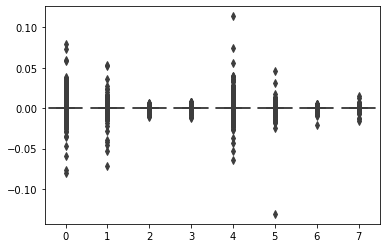

In [55]:
sns.boxplot(data = ((gradient_lambda0_e1000_full)).detach(), showfliers = True)

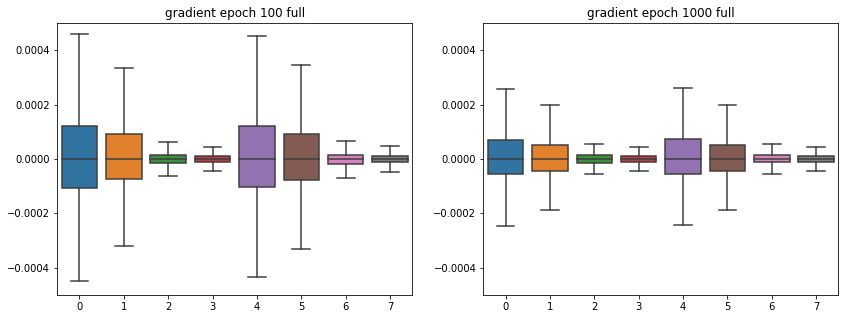

In [56]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
ax1.set_ylim([-0.0005,0.0005])
ax2.set_ylim([-0.0005,0.0005])
ax1.title.set_text('gradient epoch 100 full')
ax2.title.set_text('gradient epoch 1000 full')
sns.boxplot(data = ((gradient_lambda0_e100_full)).detach(), ax = ax1, showfliers = False)
sns.boxplot(data = ((gradient_lambda0_e1000_full)).detach(), ax = ax2, showfliers = False)
plt.show()

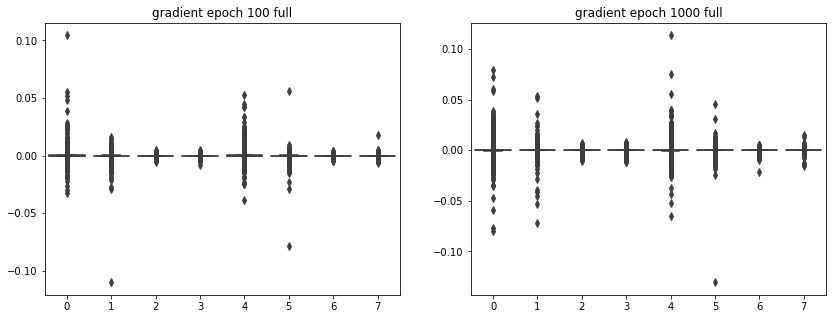

In [57]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
# ax1.set_ylim([-0.0005,0.0005])
# ax2.set_ylim([-0.0005,0.0005])
ax1.title.set_text('gradient epoch 100 full')
ax2.title.set_text('gradient epoch 1000 full')
sns.boxplot(data = ((gradient_lambda0_e100_full)).detach(), ax = ax1)
sns.boxplot(data = ((gradient_lambda0_e1000_full)).detach(), ax = ax2)
plt.show()

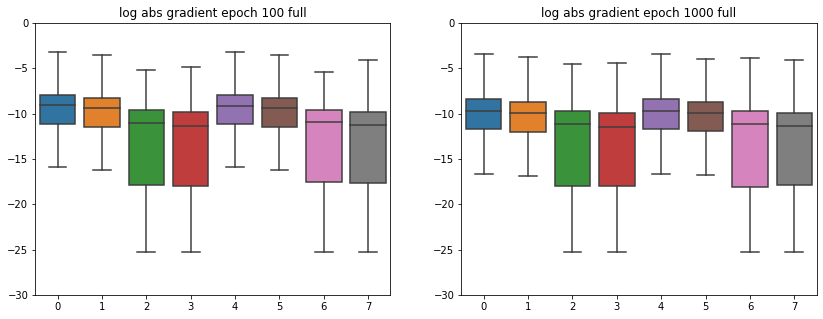

In [58]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
ax1.set_ylim([-30,0])
ax2.set_ylim([-30,0])
ax1.title.set_text('log abs gradient epoch 100 full')
ax2.title.set_text('log abs gradient epoch 1000 full')
sns.boxplot(data = torch.log(torch.abs(gradient_lambda0_e100_full)+0.00000000001).detach(), ax = ax1, showfliers = False)
sns.boxplot(data = torch.log(torch.abs(gradient_lambda0_e1000_full)+0.00000000001).detach(), ax = ax2, showfliers = False)
plt.show()

# 100 epochs original simclr vs with gradient penalty lambda = 5

In [59]:
gradient_lambda5_e100_full = cal_gradient_lambda_full(resume = 'resnet18_aam_new_gp5_0_n1.pth99', norm = 1, lambda_gp = 5)

==> Building model..
==> Resuming from checkpoint..

Epoch: 100


gp: 0.00135 ,  loss: 5.462,  final_loss: 5.469: ██████████| 98/98 [00:58<00:00,  1.68it/s]


In [60]:
gradient_lambda10_e100_full = cal_gradient_lambda_full(resume = 'resnet18_realaam_gp_10_0_n1.pth99', norm = 1, lambda_gp = 10)

==> Building model..
==> Resuming from checkpoint..

Epoch: 100


gp: 0.00133 ,  loss: 5.468,  final_loss: 5.482: ██████████| 98/98 [00:58<00:00,  1.67it/s]


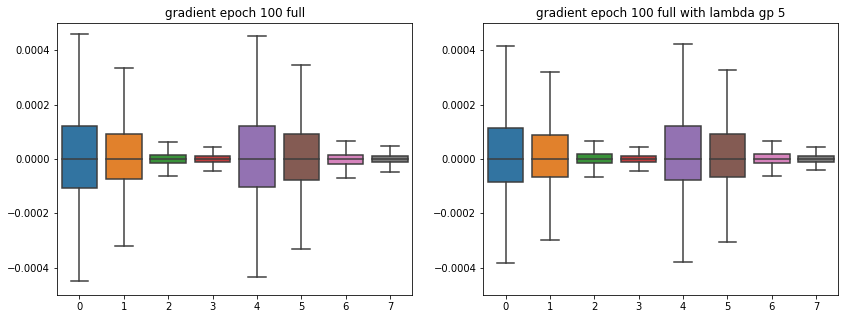

In [61]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
ax1.set_ylim([-0.0005,0.0005])
ax2.set_ylim([-0.0005,0.0005])
ax1.title.set_text('gradient epoch 100 full')
ax2.title.set_text('gradient epoch 100 full with lambda gp 5')
sns.boxplot(data = ((gradient_lambda0_e100_full)).detach(), ax = ax1, showfliers = False)
sns.boxplot(data = ((gradient_lambda5_e100_full)).detach(), ax = ax2, showfliers = False)
plt.show()

varinace of 100 epochs vs 1000 epoch

In [62]:
gradient_lambda0_e100_full.var(dim = 0)

tensor([1.3520e-06, 6.1596e-07, 2.8725e-08, 3.1165e-08, 1.1495e-06, 5.1528e-07,
        3.2879e-08, 3.8187e-08])

In [63]:
gradient_lambda0_e1000_full.var(dim = 0)

tensor([2.5401e-06, 8.2909e-07, 6.5902e-08, 7.0787e-08, 2.1691e-06, 7.4610e-07,
        6.6494e-08, 7.9001e-08])

In [64]:
gradient_lambda0_e100_full.norm(p = 2, dim = 0)

tensor([0.2601, 0.1755, 0.0379, 0.0395, 0.2399, 0.1605, 0.0406, 0.0437])

In [65]:
gradient_lambda0_e1000_full.norm(p = 2, dim = 0)

tensor([0.3565, 0.2036, 0.0574, 0.0595, 0.3295, 0.1931, 0.0577, 0.0628])

In [66]:
gradient_lambda0_e100_full.norm(p = 1, dim = 0)

tensor([18.2177, 11.9228,  3.3124,  2.9970, 17.8847, 12.0303,  3.5127,  3.1400])

In [67]:
gradient_lambda0_e1000_full.norm(p = 1, dim = 0)

tensor([18.1795, 10.1346,  3.7118,  3.4127, 17.3027,  9.7652,  3.6772,  3.5167])

In [68]:
gradient_lambda0_e100_full.norm(p = 0.5, dim = 0).mean()/512

tensor(435.4576)

In [69]:
gradient_lambda0_e1000_full.norm(p = 0.5, dim = 0).mean()/512

tensor(341.8886)

In [70]:
(gradient_lambda0_e100_full+1e-16).norm(p = 0.5, dim = 0).mean()/512

tensor(435.4576)

In [71]:
(gradient_lambda0_e1000_full+1e-16).norm(p = 0.5, dim = 0).mean()/512

tensor(341.8886)

In [72]:
gradient_lambda1_n0_5_e100_full = cal_gradient_lambda_full(resume = 'resnet18_aam_gp_1_0_n0_5.pth99', norm = 1, lambda_gp = 0)

==> Building model..
==> Resuming from checkpoint..

Epoch: 100


gp: 0.00141 ,  loss: 5.538,  final_loss: 5.538: ██████████| 98/98 [00:57<00:00,  1.71it/s]


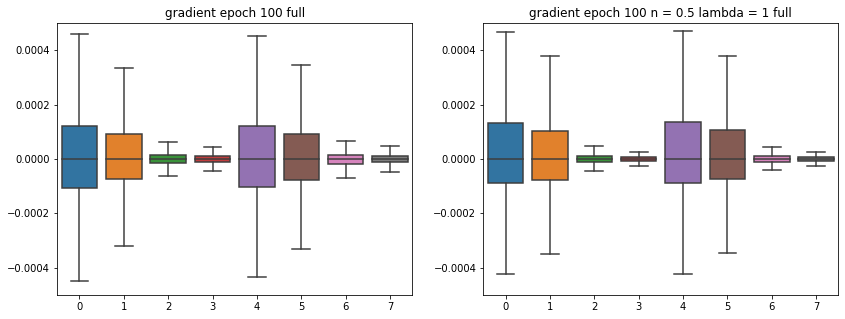

In [73]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
ax1.set_ylim([-0.0005,0.0005])
ax2.set_ylim([-0.0005,0.0005])
ax1.title.set_text('gradient epoch 100 full')
ax2.title.set_text('gradient epoch 100 n = 0.5 lambda = 1 full')
sns.boxplot(data = ((gradient_lambda0_e100_full)).detach(), ax = ax1, showfliers = False)
sns.boxplot(data = ((gradient_lambda1_n0_5_e100_full)).detach(), ax = ax2, showfliers = False)
plt.show()

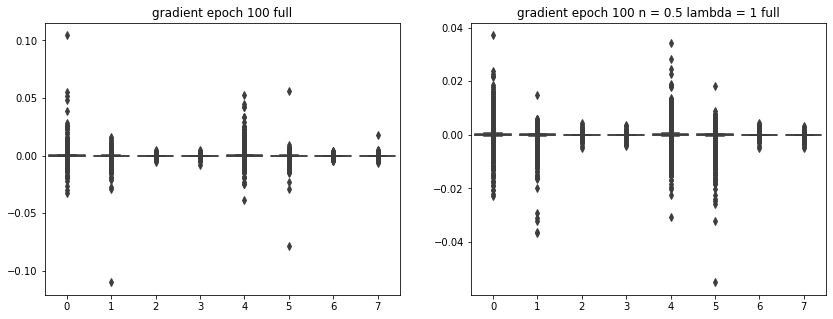

In [79]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
# ax1.set_ylim([-0.0005,0.0005])
# ax2.set_ylim([-0.0005,0.0005])
ax1.title.set_text('gradient epoch 100 full')
ax2.title.set_text('gradient epoch 100 n = 0.5 lambda = 1 full')
sns.boxplot(data = ((gradient_lambda0_e100_full)).detach(), ax = ax1, showfliers = True)
sns.boxplot(data = ((gradient_lambda1_n0_5_e100_full)).detach(), ax = ax2, showfliers = True)
plt.show()

In [74]:
(gradient_lambda1_n0_5_e100_full+1e-16).norm(p = 0.5, dim = 0).mean()/512

tensor(422.2264)

In [75]:
(gradient_lambda0_e100_full+1e-16).norm(p = 0.5, dim = 0).mean()/512

tensor(435.4576)

In [77]:
gradient_lambda0_e100_full[:,0].norm(p=0.5)

tensor(446916.3125)

In [78]:
gradient_lambda1_n0_5_e100_full[:,0].norm(p=0.5)

tensor(436711.1562)

In [80]:
gradient_lambda0_e100_full.var(dim = 0)

tensor([1.3520e-06, 6.1596e-07, 2.8725e-08, 3.1165e-08, 1.1495e-06, 5.1528e-07,
        3.2879e-08, 3.8187e-08])

In [81]:
gradient_lambda0_e1000_full.var(dim = 0)

tensor([2.5401e-06, 8.2909e-07, 6.5902e-08, 7.0787e-08, 2.1691e-06, 7.4610e-07,
        6.6494e-08, 7.9001e-08])

In [83]:
gradient_lambda0_e100_full.norm(p=2, dim = 0)

tensor([0.2601, 0.1755, 0.0379, 0.0395, 0.2399, 0.1605, 0.0406, 0.0437])

In [84]:
gradient_lambda0_e1000_full.norm(p=2, dim = 0)

tensor([0.3565, 0.2036, 0.0574, 0.0595, 0.3295, 0.1931, 0.0577, 0.0628])

In [92]:
gradient_lambda0_e1000_full.norm(p=2, dim = 0).var()

tensor(0.0158)

In [93]:
gradient_lambda0_e100_full.norm(p=2, dim = 0).var()

tensor(0.0091)

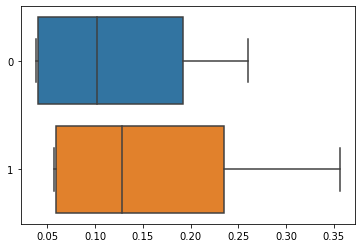

In [114]:
sns.boxplot(data = [gradient_lambda0_e100_full.norm(p=2, dim = 0), gradient_lambda0_e1000_full.norm(p=2, dim = 0)], orient = 'h')

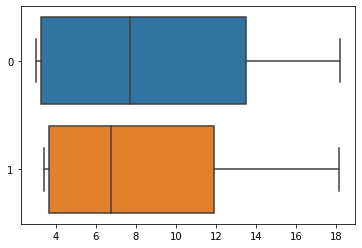

In [115]:
sns.boxplot(data = [gradient_lambda0_e100_full.norm(p=1, dim = 0), gradient_lambda0_e1000_full.norm(p=1, dim = 0)], orient = 'h')

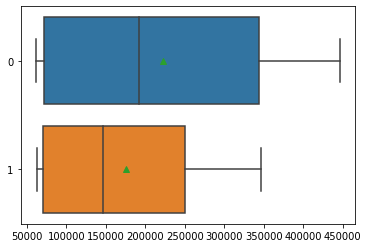

In [127]:
sns.boxplot(data = [(gradient_lambda0_e100_full+1e-16).norm(p=0.5, dim = 0), (gradient_lambda0_e1000_full+1e-16).norm(p=0.5, dim = 0)], orient = 'h', showmeans = True)

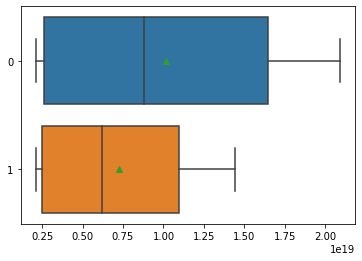

In [128]:
sns.boxplot(data = [(gradient_lambda0_e100_full+1e-16).norm(p=0.2, dim = 0), (gradient_lambda0_e1000_full+1e-16).norm(p=0.2, dim = 0)], orient = 'h', showmeans = True)

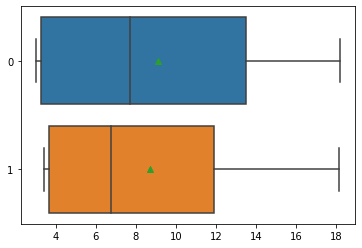

In [129]:
sns.boxplot(data = [(gradient_lambda0_e100_full+1e-16).norm(p=1, dim = 0), (gradient_lambda0_e1000_full+1e-16).norm(p=1, dim = 0)], orient = 'h', showmeans = True)

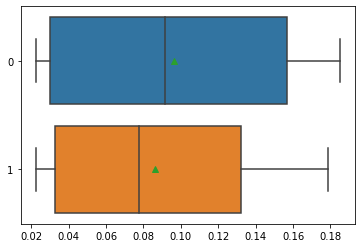

In [131]:
sns.boxplot(data = [(gradient_lambda0_e100+1e-16).norm(p=1, dim = 0).detach(), (gradient_lambda0_e1000+1e-16).norm(p=1, dim = 0).detach()], orient = 'h', showmeans = True)

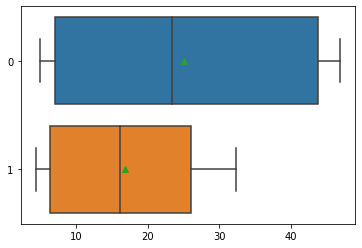

In [132]:
sns.boxplot(data = [(gradient_lambda0_e100+1e-16).norm(p=0.5, dim = 0).detach(), (gradient_lambda0_e1000+1e-16).norm(p=0.5, dim = 0).detach()], orient = 'h', showmeans = True)

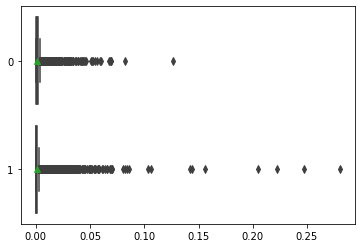

In [15]:
sns.boxplot(data = [(gradient_lambda0_e100_full+1e-16).norm(p=1, dim = 1).detach(), (gradient_lambda0_e1000_full+1e-16).norm(p=1, dim = 1).detach()], orient = 'h', showmeans = True)

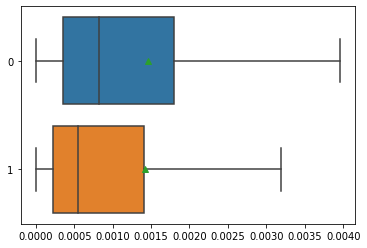

In [17]:
sns.boxplot(data = [(gradient_lambda0_e100_full+1e-16).norm(p=1, dim = 1).detach(), (gradient_lambda0_e1000_full+1e-16).norm(p=1, dim = 1).detach()], orient = 'h', showmeans = True, showfliers = False)

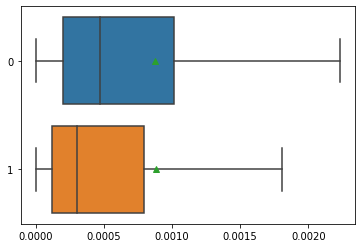

In [18]:
sns.boxplot(data = [(gradient_lambda0_e100_full+1e-16).norm(p=2, dim = 1).detach(), (gradient_lambda0_e1000_full+1e-16).norm(p=2, dim = 1).detach()], orient = 'h', showmeans = True, showfliers = False)

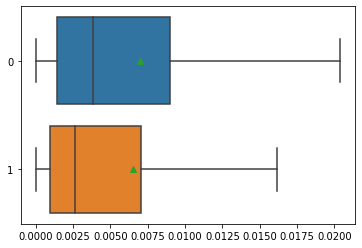

In [19]:
sns.boxplot(data = [(gradient_lambda0_e100_full+1e-16).norm(p=0.5, dim = 1).detach(), (gradient_lambda0_e1000_full+1e-16).norm(p=0.5, dim = 1).detach()], orient = 'h', showmeans = True, showfliers = False)

In [ ]:
sns.boxplot(data = [(gradient_lambda0_e100_full+1e-16).norm(p=0.1, dim = 1).detach(), (gradient_lambda0_e1000_full+1e-16).norm(p=0.1, dim = 1).detach()], orient = 'h', showmeans = True, showfliers = False)

# New gradient penalty

In [55]:
gradient_max = 0.015

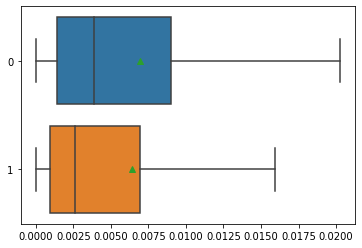

In [58]:
sns.boxplot(data = [(gradient_lambda0_e100_full+1e-16).norm(p=0.5, dim = 1).detach(), (gradient_lambda0_e1000_full+1e-16).norm(p=0.5, dim = 1).detach()], orient = 'h', showmeans = True, showfliers = False)

In [60]:
gradient_lambda0_e100_full.size()

torch.Size([50000, 8])

In [61]:
gradient_lambda0_e1000_full.size()

torch.Size([50000, 8])

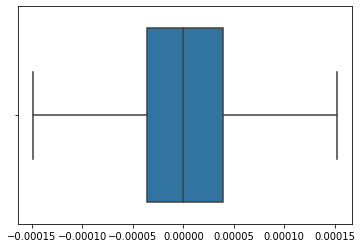

In [65]:
sns.boxplot(gradient_lambda0_e100_full, showfliers = False)

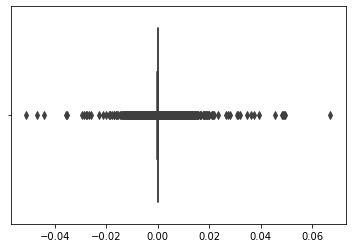

In [66]:
sns.boxplot(gradient_lambda0_e100_full, showfliers = True)

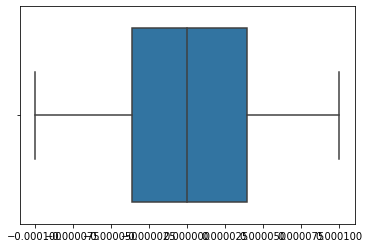

In [71]:
sns.boxplot(gradient_lambda0_e100_full.clamp(min = -0.0001, max = 0.0001), showfliers = True)

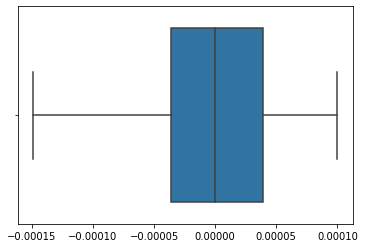

In [67]:
sns.boxplot(gradient_lambda0_e100_full.clamp(max = 0.0001), showfliers = False)

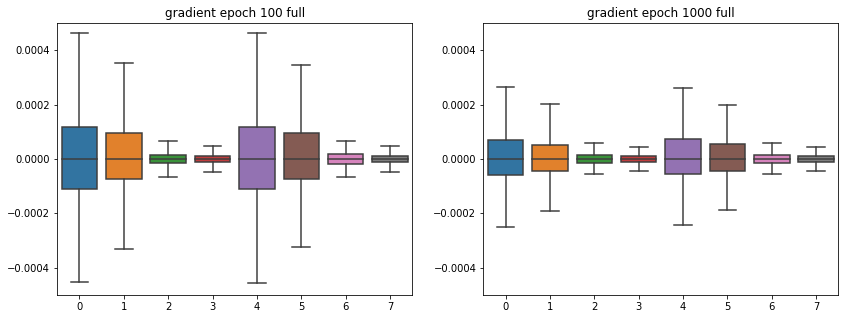

In [76]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
ax1.set_ylim([-0.0005,0.0005])
ax2.set_ylim([-0.0005,0.0005])
ax1.title.set_text('gradient epoch 100 full')
ax2.title.set_text('gradient epoch 1000 full')
sns.boxplot(data = ((gradient_lambda0_e100_full)).detach(), ax = ax1, showfliers = False)
sns.boxplot(data = ((gradient_lambda0_e1000_full)).detach(), ax = ax2, showfliers = False)
plt.show()

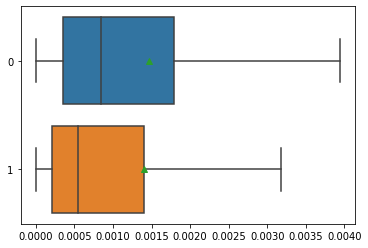

In [78]:
sns.boxplot(data = [(gradient_lambda0_e100_full+1e-16).norm(p=1, dim = 1).detach(),
                    (gradient_lambda0_e1000_full+1e-16).norm(p=1, dim = 1).detach()], orient = 'h', showmeans = True, showfliers = False)

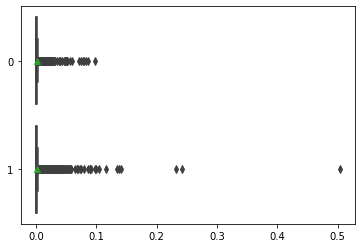

In [79]:
sns.boxplot(data = [(gradient_lambda0_e100_full+1e-16).norm(p=1, dim = 1).detach(),
                    (gradient_lambda0_e1000_full+1e-16).norm(p=1, dim = 1).detach()], orient = 'h', showmeans = True, showfliers = True)

In [87]:
a100 = (gradient_lambda0_e100_full+1e-16).norm(p=1, dim = 1).detach()
a1000 = (gradient_lambda0_e1000_full+1e-16).norm(p=1, dim = 1).detach()

In [92]:
np.quantile(np.array(a100), 0.25)

0.00035584291617851704

In [93]:
np.quantile(np.array(a100), 0.75)

0.0017920736863743514

In [94]:
np.quantile(np.array(a1000), 0.25)

0.00021595911312033422

In [95]:
np.quantile(np.array(a1000), 0.75)

0.0013997920032124966

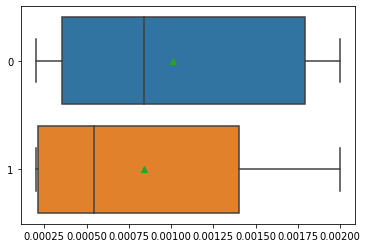

In [100]:
sns.boxplot(data = [a100.clamp(min = 0.0002, max = 0.002),
                    a1000.clamp(min = 0.0002, max = 0.002)], orient = 'h', showmeans = True, showfliers = True)

In [115]:
a100.clamp(min = 0.0002, max = 0.002).mean()

tensor(0.0010)

In [116]:
a1000.clamp(min = 0.0002, max = 0.002).mean()

tensor(0.0008)

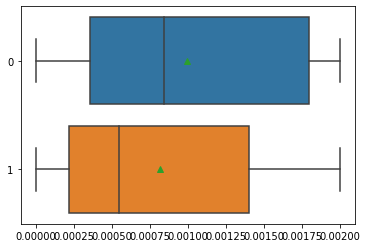

In [114]:
sns.boxplot(data = [a100.clamp(min = 0, max = 0.002),
                    a1000.clamp(min = 0, max = 0.002)], orient = 'h', showmeans = True, showfliers = True)

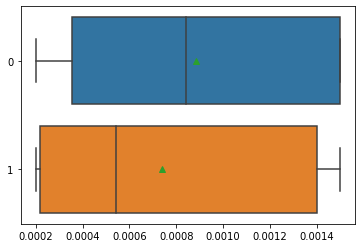

In [102]:
sns.boxplot(data = [a100.clamp(min = 0.0002, max = 0.0015),
                    a1000.clamp(min = 0.0002, max = 0.0015)], orient = 'h', showmeans = True, showfliers = True)

In [103]:
b100 = (gradient_lambda0_e100_full+1e-16).norm(p=0.8, dim = 1).detach()
b1000 = (gradient_lambda0_e1000_full+1e-16).norm(p=0.8, dim = 1).detach()

In [105]:
np.quantile(np.array(b100), 0.25)

0.0004945857945131138

In [107]:
np.quantile(np.array(b100), 0.75)

0.002579167135991156

In [108]:
np.quantile(np.array(b1000), 0.25)

0.00030543184402631596

In [109]:
np.quantile(np.array(b1000), 0.75)

0.0020112511701881886

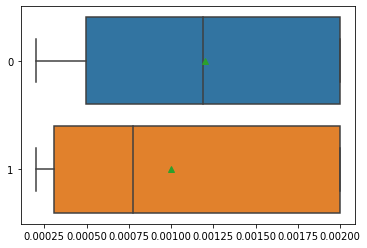

In [112]:
sns.boxplot(data = [b100.clamp(min = 0.0002, max = 0.002),
                    b1000.clamp(min = 0.0002, max = 0.002)], orient = 'h', showmeans = True, showfliers = True)

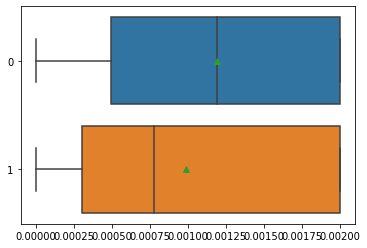

In [113]:
sns.boxplot(data = [b100.clamp(min = 0, max = 0.002),
                    b1000.clamp(min = 0, max = 0.002)], orient = 'h', showmeans = True, showfliers = True)

In [8]:
my_resume_from = os.path.join('./checkpoint', 'resnet18_aam_gp_200_0_clamp.pth49')
my_checkpoint = torch.load(my_resume_from)

In [9]:
my_checkpoint['test_acc']

[53.4, 63.01, 67.02, 69.39, 71.3]

In [10]:
my_resume_from = os.path.join('./checkpoint', 'resnet18_aam_gp_30_0_clamp.pth49')
my_checkpoint = torch.load(my_resume_from)
my_checkpoint['test_acc']

[54.41, 66.52, 71.24, 73.97, 75.24]

In [ ]:
my_resume_from = os.path.join('./checkpoint', 'resnet18_aam_gp_10_0_clamp.pth49')
my_checkpoint = torch.load(my_resume_from)
my_checkpoint['test_acc']

In [4]:
my_resume_from = os.path.join('./checkpoint', 'resnet18_aam_gp_10_0_clamp.pth99')
my_checkpoint_clamp10 = torch.load(my_resume_from)
acc_clamp10 = my_checkpoint_clamp10['test_acc']
print(acc_clamp10)

[53.22, 65.44, 70.81, 73.47, 75.59, 76.4, 77.27, 78.24, 79.07, 79.45]


In [5]:
my_checkpoint_clamp10['contrastive_loss']

[tensor(5.9443, device='cuda:0', requires_grad=True),
 tensor(5.6940, device='cuda:0', requires_grad=True),
 tensor(5.6098, device='cuda:0', requires_grad=True),
 tensor(5.5592, device='cuda:0', requires_grad=True),
 tensor(5.5344, device='cuda:0', requires_grad=True),
 tensor(5.5118, device='cuda:0', requires_grad=True),
 tensor(5.4951, device='cuda:0', requires_grad=True),
 tensor(5.4790, device='cuda:0', requires_grad=True),
 tensor(5.4718, device='cuda:0', requires_grad=True),
 tensor(5.4585, device='cuda:0', requires_grad=True)]

In [84]:
my_resume_from = os.path.join('./checkpoint', 'resnet18_aam_gp_30_0_clamp.pth99')
my_checkpoint_clamp30 = torch.load(my_resume_from)
acc_clamp30 = my_checkpoint_clamp30['test_acc']
print(acc_clamp30)

[54.41, 66.52, 71.24, 73.97, 75.24, 76.23, 77.28, 78.04, 78.4, 79.37]


In [85]:
my_resume_from = os.path.join('./checkpoint', 'resnet18_aam_baseline2.pth99')
my_checkpoint = torch.load(my_resume_from)
acc_base = my_checkpoint['test_acc']
print(acc_base)

[53.59, 66.25, 70.97, 73.62, 74.86, 75.75, 76.8, 77.82, 78.76, 79.28]


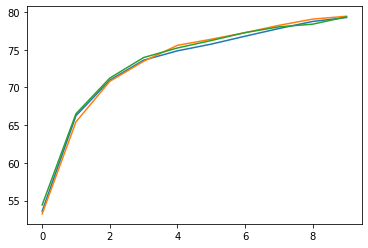

In [34]:
plt.plot(acc_base)
plt.plot(acc_clamp10)
plt.plot(acc_clamp30)

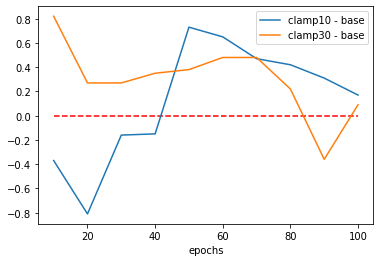

In [55]:
plt.plot([i*10 for i in range(1,11)], np.array(acc_clamp10) - np.array(acc_base), label = 'clamp10 - base')
plt.plot([i*10 for i in range(1,11)],np.array(acc_clamp30) - np.array(acc_base), label = 'clamp30 - base')
plt.hlines(xmin = 10, xmax = 100, y = 0, linestyles='--', color = 'r')
plt.legend()
plt.xlabel('epochs')
plt.show()

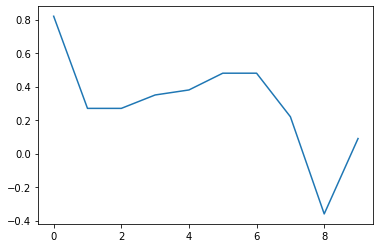

In [7]:
my_resume_from = os.path.join('./checkpoint', 'resnet18_aam_new_baseline_rerun.pth99')
my_checkpoint = torch.load(my_resume_from)

In [8]:
my_checkpoint.keys()

dict_keys(['net', 'clf', 'critic', 'epoch', 'args', 'script', 'base_optim', 'encoder_optim', 'num_epochs'])

In [20]:
gradient_lambda0_e100_clamp_full = cal_gradient_lambda_full(resume = 'resnet18_aam_gp_10_0_clamp.pth99', norm = 1, lambda_gp = 0)

==> Building model..
==> Resuming from checkpoint..

Epoch: 100


gp: 0.00147 ,  loss: 5.465,  final_loss: 5.465: ██████████| 98/98 [00:55<00:00,  1.78it/s]


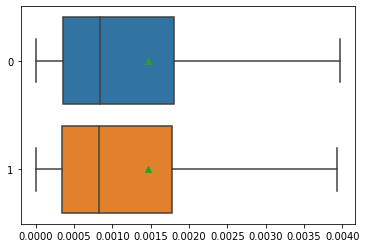

In [21]:
sns.boxplot(data = [(gradient_lambda0_e100_full+1e-16).norm(p=1, dim = 1).detach(), (gradient_lambda0_e100_clamp_full+1e-16).norm(p=1, dim = 1).detach()], orient = 'h', showmeans = True, showfliers = False)

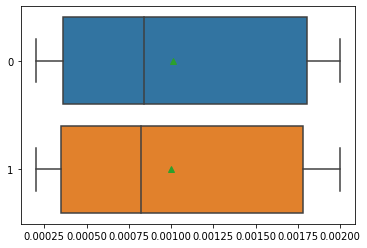

In [23]:
sns.boxplot(data = [(gradient_lambda0_e100_full+1e-16).norm(p=1, dim = 1).clamp(min = 0.0002, max = 0.002).detach(), (gradient_lambda0_e100_clamp_full+1e-16).norm(p=1, dim = 1).clamp(min = 0.0002, max = 0.002).detach()], orient = 'h', showmeans = True, showfliers = False)

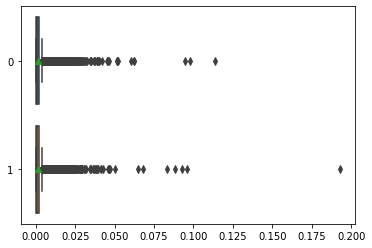

In [22]:
sns.boxplot(data = [(gradient_lambda0_e100_full+1e-16).norm(p=1, dim = 1).detach(), (gradient_lambda0_e100_clamp_full+1e-16).norm(p=1, dim = 1).detach()], orient = 'h', showmeans = True, showfliers = True)

In [19]:
gradient_lambda0_e50_full = cal_gradient_lambda_full(resume = 'resnet18_aam_new_baseline_rerun.pth49', norm = 1, lambda_gp = 0)

==> Building model..
==> Resuming from checkpoint..

Epoch: 50


gp: 0.00161 ,  loss: 5.532,  final_loss: 5.532: ██████████| 98/98 [00:57<00:00,  1.71it/s]


In [20]:
gradient_lambda0_e50_full_clamp10 = cal_gradient_lambda_full(resume = 'resnet18_aam_gp_10_0_clamp.pth49', norm = 1, lambda_gp = 0)

==> Building model..
==> Resuming from checkpoint..

Epoch: 50


gp: 0.00156 ,  loss: 5.531,  final_loss: 5.531: ██████████| 98/98 [00:56<00:00,  1.74it/s]


In [21]:
gradient_lambda0_e50_full_clamp30 = cal_gradient_lambda_full(resume = 'resnet18_aam_gp_30_0_clamp.pth49', norm = 1, lambda_gp = 0)

==> Building model..
==> Resuming from checkpoint..

Epoch: 50


gp: 0.00146 ,  loss: 5.536,  final_loss: 5.536: ██████████| 98/98 [00:57<00:00,  1.71it/s]


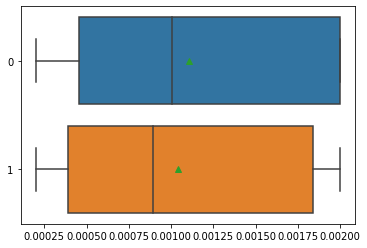

In [23]:
sns.boxplot(data = [(gradient_lambda0_e50_full+1e-16).norm(p=1, dim = 1).clamp(min = 0.0002, max = 0.002).detach(), (gradient_lambda0_e50_full_clamp30+1e-16).norm(p=1, dim = 1).clamp(min = 0.0002, max = 0.002).detach()], orient = 'h', showmeans = True, showfliers = False)

In [8]:
gradient_lambda0_e100_full_clamp30 = cal_gradient_lambda_full(resume = 'resnet18_aam_gp_30_0_clamp.pth99', norm = 1, lambda_gp = 0)

==> Building model..
==> Resuming from checkpoint..

Epoch: 100


gp: 0.00132 ,  loss: 5.462,  final_loss: 5.462: ██████████| 98/98 [00:59<00:00,  1.64it/s]


In [9]:
gradient_lambda0_e100_full = cal_gradient_lambda_full(resume = 'resnet18_aam_new_baseline_rerun.pth99', norm = 1, lambda_gp = 0)

==> Building model..
==> Resuming from checkpoint..

Epoch: 100


gp: 0.00150 ,  loss: 5.458,  final_loss: 5.458: ██████████| 98/98 [00:57<00:00,  1.71it/s]


In [19]:
gradient_lambda0_e100_full_clamp10 = cal_gradient_lambda_full(resume = 'resnet18_aam_gp_10_0_clamp.pth99', norm = 1, lambda_gp = 0)

==> Building model..
==> Resuming from checkpoint..

Epoch: 100


gp: 0.00147 ,  loss: 5.461,  final_loss: 5.461: ██████████| 98/98 [00:54<00:00,  1.80it/s]


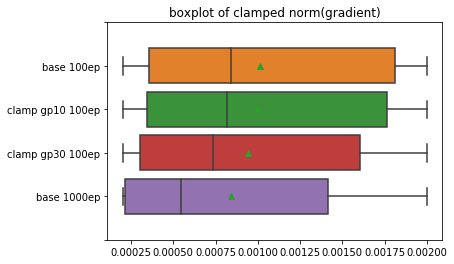

In [82]:
sns.boxplot(data = [[],(gradient_lambda0_e100_full+1e-16).norm(p=1, dim = 1).clamp(min = 0.0002, max = 0.002).detach(),
                     (gradient_lambda0_e100_full_clamp10+1e-16).norm(p=1, dim = 1).clamp(min = 0.0002, max = 0.002).detach(),
                    (gradient_lambda0_e100_full_clamp30+1e-16).norm(p=1, dim = 1).clamp(min = 0.0002, max = 0.002).detach(),   
                    (gradient_lambda0_e1000_full+1e-16).norm(p=1, dim = 1).clamp(min = 0.0002, max = 0.002).detach()], orient = 'h', showmeans = True, showfliers = False)
plt.yticks(np.arange(6), ['','base 100ep', 'clamp gp10 100ep', 'clamp gp30 100ep','base 1000ep'])
plt.title('boxplot of clamped norm(gradient)')
plt.show()


In [75]:
np.arange(5)

array([0, 1, 2, 3, 4])

# look at representation h

In [6]:
def cal_h_full(resume, norm, lambda_gp):
    # config
    ### config ####
    representation_list = []

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    base_lr = 0.25
    arch = 'resnet18'
    momentum = 0.9
    cosine_anneal = True
    num_epochs = 1
    test_freq = 1
    lr = base_lr * (batch_size / 256)
    
    best_acc = 0  # best test accuracy
    start_epoch = 0  # start from epoch 0 or last checkpoint epoch
    last_epoch = num_epochs #last epoch or from last epoch from checkpoint 
    clf = None
    current_checkpoint = {}
    acc = 0
    # Model
    print('==> Building model..')
    ##############################################################
    # Encoder
    ##############################################################
    if arch == 'resnet18':
        net = ResNet18(stem=stem)
    elif arch == 'resnet34':
        net = ResNet34(stem=stem)
    elif arch == 'resnet50':
        net = ResNet50(stem=stem)
    else:
        raise ValueError("Bad architecture specification")
    net = net.to(device)

    ##############################################################
    # Critic
    ##############################################################
    critic = LinearCritic(net.representation_dim, temperature=temperature).to(device)

    ###### Differentiable augmentation ######
    brightness_bound = [0.2, 1.8]
    contrast_bound = [0.2, 1.8]
    saturation_bound = [0.2, 1.8]
    hue_bound = [-0.2, 0.2]

    if device == 'cuda':
        repr_dim = net.representation_dim
        net = torch.nn.DataParallel(net)
        net.representation_dim = repr_dim
        cudnn.benchmark = True

    criterion = nn.CrossEntropyLoss()
    base_optimizer = optim.SGD(list(net.parameters()) + list(critic.parameters()), lr=lr, weight_decay=1e-6,
                               momentum=momentum)
    if cosine_anneal == True:
        scheduler = CosineAnnealingWithLinearRampLR(base_optimizer, num_epochs)
    encoder_optimizer = LARS(base_optimizer, trust_coef=1e-3)

    #Resume
    if resume:
        # Load checkpoint.
        print('==> Resuming from checkpoint..')
        assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
        resume_from = os.path.join('./checkpoint', resume)
        checkpoint = torch.load(resume_from)
        net.load_state_dict(checkpoint['net'])
        critic.load_state_dict(checkpoint['critic'])
    #     best_acc = checkpoint['acc']
        start_epoch = checkpoint['epoch'] + 1
        encoder_optimizer.load_state_dict(checkpoint['encoder_optim'])
        base_optimizer.load_state_dict(checkpoint['base_optim'])
        scheduler.step(start_epoch)
        if 'num_epochs' in checkpoint:
            last_epoch = checkpoint['num_epochs']
        else:
            last_epoch = 1000 #default value for num epochs = 1000
        current_checkpoint = checkpoint
        ##### Train #####
        print('\nEpoch: %d' % start_epoch)
#         net.train()
#         critic.train()
        net.eval()
        critic.eval()
        train_loss = 0
        sum_gradient = 0
        train_loss_nogp = 0
        t = tqdm(enumerate(trainloader), desc='Loss: **** ', total=len(trainloader), bar_format='{desc}{bar}{r_bar}')
        for batch_idx, (inputs, _, _) in t:
            x1, x2 = inputs
            x1, x2 = x1.to(device), x2.to(device)

            #colour augmentation
            B = x1.size()[0]
            brightness_list1, saturation_list1, contrast_list1, hue_list1 = gen_lambda(B, brightness_bound,
                                                                                       contrast_bound,
                                                                                       saturation_bound,
                                                                                       hue_bound)
            brightness_list2, saturation_list2, contrast_list2, hue_list2 = gen_lambda(B, brightness_bound,
                                                                                       contrast_bound,
                                                                                       saturation_bound,
                                                                                       hue_bound)
            lambda_ = torch.stack([brightness_list1, saturation_list1, contrast_list1, hue_list1,
                                   brightness_list2, saturation_list2, contrast_list2, hue_list2], dim=1)
            aug_manual1 = DifferentiableColourDistortionByTorch_manual(brightness = lambda_[:,0],
                                                                       contrast = lambda_[:,1],
                                                                       saturation = lambda_[:,2],
                                                                       hue = lambda_[:,3])
            aug_manual2 = DifferentiableColourDistortionByTorch_manual(brightness = lambda_[:,4],
                                                                       contrast = lambda_[:,5],
                                                                       saturation = lambda_[:,6],
                                                                       hue = lambda_[:,7])

            x1, x2 = aug_manual1(x1), aug_manual2(x2)
            x1, x2 = ManualNormalise(x1, dataset), ManualNormalise(x2, dataset)

            encoder_optimizer.zero_grad()
            representation1, representation2 = net(x1), net(x2)

            return representation1

In [7]:
hlambda0_e100_full = cal_h_full(resume = 'resnet18_aam_new_baseline_rerun.pth99', norm = 1, lambda_gp = 0)

==> Building model..
==> Resuming from checkpoint..

Epoch: 100


Loss: ****           | 0/98 [00:01<?, ?it/s]


In [8]:
hlambda0_e1000_full = cal_h_full(resume = 'resnet18_aam_new_baseline_rerun.pth999', norm = 1, lambda_gp = 0)

==> Building model..
==> Resuming from checkpoint..

Epoch: 1000


Loss: ****           | 0/98 [00:00<?, ?it/s]


In [9]:
hlambda0_e1000_full.size()

torch.Size([512, 512])

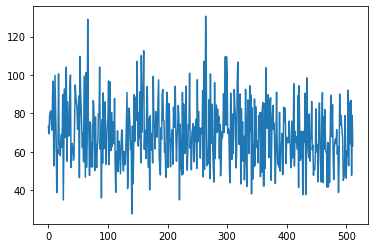

In [10]:
plt.plot(hlambda0_e1000_full.sum(dim=1).cpu().detach())

Text(0.5, 1.0, 'sum h of original simclr')

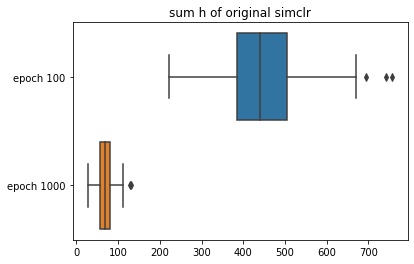

In [11]:
d = {'epoch 100': hlambda0_e100_full.sum(dim = 1).cpu().detach(), 'epoch 1000': hlambda0_e1000_full.sum(dim = 1).cpu().detach()}
df = pd.DataFrame(data=d)
sns.boxplot(data = df, orient = 'h')
plt.title('sum h of original simclr')


In [12]:
hlambda0_e100_full_clamp10 = cal_h_full(resume = 'resnet18_aam_gp_10_0_clamp.pth99', norm = 1, lambda_gp = 0)

==> Building model..
==> Resuming from checkpoint..

Epoch: 100


Loss: ****           | 0/98 [00:00<?, ?it/s]


Text(0.5, 1.0, 'sum h of original simclr')

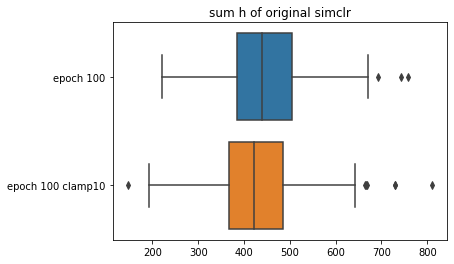

In [13]:
d = {'epoch 100': hlambda0_e100_full.sum(dim = 1).cpu().detach(), 'epoch 100 clamp10': hlambda0_e100_full_clamp10.sum(dim = 1).cpu().detach()}
df = pd.DataFrame(data=d)
sns.boxplot(data = df, orient = 'h')
plt.title('sum h of original simclr')


# calculate gradient of h

In [7]:
def cal_grad_h_full(resume):
    # config
    ### config ####
    gradient_lambda_list = []
    representation_list = []

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    base_lr = 0.25
    arch = 'resnet18'
    momentum = 0.9
    cosine_anneal = True
    num_epochs = 1
    test_freq = 1
    lr = base_lr * (batch_size / 256)
    
    best_acc = 0  # best test accuracy
    start_epoch = 0  # start from epoch 0 or last checkpoint epoch
    last_epoch = num_epochs #last epoch or from last epoch from checkpoint 
    clf = None
    current_checkpoint = {}
    acc = 0
    # Model
    print('==> Building model..')
    ##############################################################
    # Encoder
    ##############################################################
    if arch == 'resnet18':
        net = ResNet18(stem=stem)
    elif arch == 'resnet34':
        net = ResNet34(stem=stem)
    elif arch == 'resnet50':
        net = ResNet50(stem=stem)
    else:
        raise ValueError("Bad architecture specification")
    net = net.to(device)

    ##############################################################
    # Critic
    ##############################################################
    critic = LinearCritic(net.representation_dim, temperature=temperature).to(device)

    ###### Differentiable augmentation ######
    brightness_bound = [0.2, 1.8]
    contrast_bound = [0.2, 1.8]
    saturation_bound = [0.2, 1.8]
    hue_bound = [-0.2, 0.2]

    if device == 'cuda':
        repr_dim = net.representation_dim
        net = torch.nn.DataParallel(net)
        net.representation_dim = repr_dim
        cudnn.benchmark = True

    criterion = nn.CrossEntropyLoss()
    base_optimizer = optim.SGD(list(net.parameters()) + list(critic.parameters()), lr=lr, weight_decay=1e-6,
                               momentum=momentum)
    if cosine_anneal == True:
        scheduler = CosineAnnealingWithLinearRampLR(base_optimizer, num_epochs)
    encoder_optimizer = LARS(base_optimizer, trust_coef=1e-3)

    #Resume
    if resume:
        # Load checkpoint.
        print('==> Resuming from checkpoint..')
        assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
        resume_from = os.path.join('./checkpoint', resume)
        checkpoint = torch.load(resume_from)
        net.load_state_dict(checkpoint['net'])
        critic.load_state_dict(checkpoint['critic'])
    #     best_acc = checkpoint['acc']
        start_epoch = checkpoint['epoch'] + 1
        encoder_optimizer.load_state_dict(checkpoint['encoder_optim'])
        base_optimizer.load_state_dict(checkpoint['base_optim'])
        scheduler.step(start_epoch)
        if 'num_epochs' in checkpoint:
            last_epoch = checkpoint['num_epochs']
        else:
            last_epoch = 1000 #default value for num epochs = 1000
        current_checkpoint = checkpoint
        ##### Train #####
        print('\nEpoch: %d' % start_epoch)
#         net.train()
#         critic.train()
        net.eval()
        critic.eval()
        train_loss = 0
        sum_gradient = 0
        train_loss_nogp = 0
        t = tqdm(enumerate(trainloader), desc='Loss: **** ', total=len(trainloader), bar_format='{desc}{bar}{r_bar}')
        for batch_idx, (inputs, _, _) in t:
            x1, x2 = inputs
            x1, x2 = x1.to(device), x2.to(device)

            #colour augmentation
            B = x1.size()[0]
            brightness_list1, saturation_list1, contrast_list1, hue_list1 = gen_lambda(B, brightness_bound,
                                                                                       contrast_bound,
                                                                                       saturation_bound,
                                                                                       hue_bound)
            brightness_list2, saturation_list2, contrast_list2, hue_list2 = gen_lambda(B, brightness_bound,
                                                                                       contrast_bound,
                                                                                       saturation_bound,
                                                                                       hue_bound)
            lambda_ = torch.stack([brightness_list1, saturation_list1, contrast_list1, hue_list1,
                                   brightness_list2, saturation_list2, contrast_list2, hue_list2], dim=1)
            aug_manual1 = DifferentiableColourDistortionByTorch_manual(brightness = lambda_[:,0],
                                                                       contrast = lambda_[:,1],
                                                                       saturation = lambda_[:,2],
                                                                       hue = lambda_[:,3])
            aug_manual2 = DifferentiableColourDistortionByTorch_manual(brightness = lambda_[:,4],
                                                                       contrast = lambda_[:,5],
                                                                       saturation = lambda_[:,6],
                                                                       hue = lambda_[:,7])

            x1, x2 = aug_manual1(x1), aug_manual2(x2)
            x1, x2 = ManualNormalise(x1, dataset), ManualNormalise(x2, dataset)

            encoder_optimizer.zero_grad()
            representation1, representation2 = net(x1), net(x2)
            
            # gradient penalty
            sum_rep1 = representation1.sum()
            sum_rep2 = representation2.sum()
            sum_rep = sum_rep1 + sum_rep2
            
            gradient_lambda =  autograd.grad(outputs = sum_rep,
                                 inputs = lambda_,
                                 create_graph = False,
                                 retain_graph = False,
                                 only_inputs = True)[0]
            
            gradient_lambda_list.append(gradient_lambda)
            
    return torch.cat(gradient_lambda_list, dim = 0)

In [19]:
grad_sumhlambda0_e100_full_clamp10 = cal_grad_h_full(resume = 'resnet18_aam_gp_10_0_clamp.pth99')

==> Building model..
==> Resuming from checkpoint..

Epoch: 100


Loss: **** ██████████| 98/98 [00:55<00:00,  1.77it/s]


In [13]:
grad_sumhlambda0_e100_full = cal_grad_h_full(resume = 'resnet18_aam_new_baseline_rerun.pth99')

==> Building model..
==> Resuming from checkpoint..

Epoch: 100


Loss: **** ██████████| 98/98 [00:52<00:00,  1.87it/s]


In [16]:
grad_sumhlambda0_e50_full = cal_grad_h_full(resume = 'resnet18_aam_new_baseline_rerun.pth49')

==> Building model..
==> Resuming from checkpoint..

Epoch: 50


Loss: **** ██████████| 98/98 [00:52<00:00,  1.87it/s]


In [14]:
grad_sumhlambda0_e1000_full = cal_grad_h_full(resume = 'resnet18_aam_new_baseline_rerun.pth999')

==> Building model..
==> Resuming from checkpoint..

Epoch: 1000


Loss: **** ██████████| 98/98 [00:52<00:00,  1.87it/s]


In [22]:
grad_sumhlambda0_e100_full_clamp10.size()

torch.Size([50000, 8])

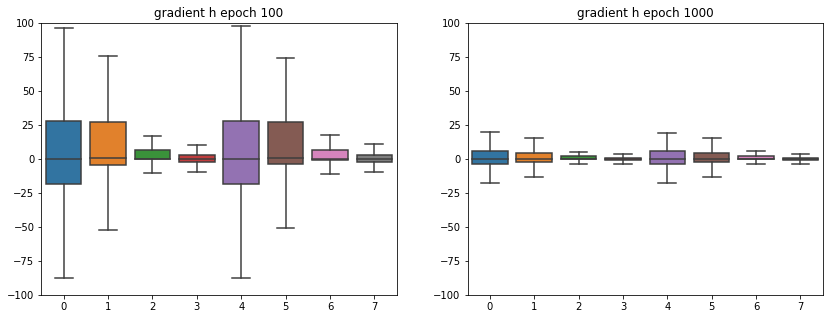

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
ax1.set_ylim([-100,100])
ax2.set_ylim([-100,100])
ax1.title.set_text('gradient h epoch 100')
ax2.title.set_text('gradient h epoch 1000')
sns.boxplot(data = ((grad_sumhlambda0_e100_full)).detach(), ax = ax1, showfliers = False)
sns.boxplot(data = ((grad_sumhlambda0_e1000_full)).detach(), ax = ax2, showfliers = False)
plt.show()

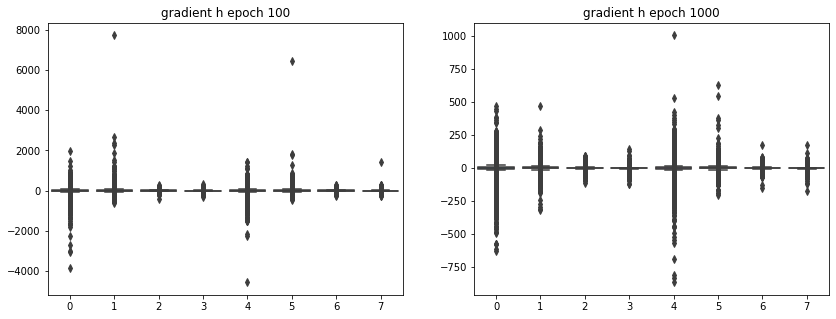

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
# ax1.set_ylim([-100,100])
# ax2.set_ylim([-100,100])
ax1.title.set_text('gradient h epoch 100')
ax2.title.set_text('gradient h epoch 1000')
sns.boxplot(data = ((grad_sumhlambda0_e100_full)).detach(), ax = ax1, showfliers = True)
sns.boxplot(data = ((grad_sumhlambda0_e1000_full)).detach(), ax = ax2, showfliers = True)
plt.show()

This may be an evidence that penalising dloss/dlambda does not help decrease the gradient dh/dlambda at all

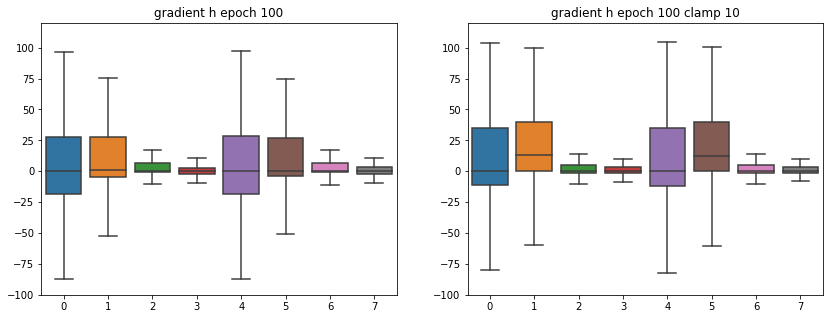

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
ax1.set_ylim([-100,120])
ax2.set_ylim([-100,120])
ax1.title.set_text('gradient h epoch 100')
ax2.title.set_text('gradient h epoch 100 clamp 10')
sns.boxplot(data = ((grad_sumhlambda0_e100_full)).detach(), ax = ax1, showfliers = False)
sns.boxplot(data = ((grad_sumhlambda0_e100_full_clamp10)).detach(), ax = ax2, showfliers = False)
plt.show()

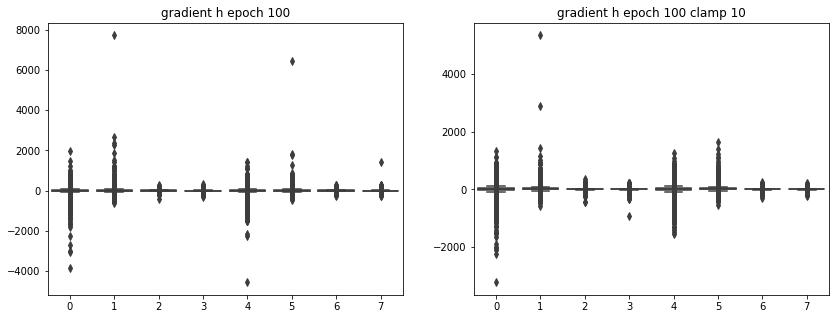

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
# ax1.set_ylim([-100,120])
# ax2.set_ylim([-100,120])
ax1.title.set_text('gradient h epoch 100')
ax2.title.set_text('gradient h epoch 100 clamp 10')
sns.boxplot(data = ((grad_sumhlambda0_e100_full)).detach(), ax = ax1, showfliers = True)
sns.boxplot(data = ((grad_sumhlambda0_e100_full_clamp10)).detach(), ax = ax2, showfliers = True)
plt.show()

# look at gradient penalty of h

Text(0.5, 1.0, 'norm 1 of gradient h')

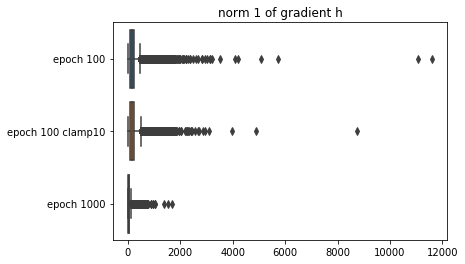

In [27]:
d = {'epoch 100': (grad_sumhlambda0_e100_full+1e-16).norm(p=1, dim = 1).detach(), 
     'epoch 100 clamp10': (grad_sumhlambda0_e100_full_clamp10+1e-16).norm(p=1, dim = 1).detach(),
     'epoch 1000': (grad_sumhlambda0_e1000_full+1e-16).norm(p=1, dim = 1).detach()}
df = pd.DataFrame(data=d)
sns.boxplot(data = df, orient = 'h')
plt.title('norm 1 of gradient h')

Text(0.5, 1.0, 'norm 1 of gradient h')

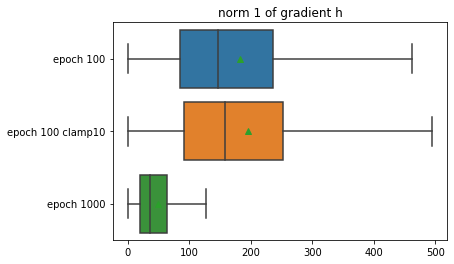

In [28]:
d = {'epoch 100': (grad_sumhlambda0_e100_full+1e-16).norm(p=1, dim = 1).detach(), 
     'epoch 100 clamp10': (grad_sumhlambda0_e100_full_clamp10+1e-16).norm(p=1, dim = 1).detach(),
     'epoch 1000': (grad_sumhlambda0_e1000_full+1e-16).norm(p=1, dim = 1).detach()}
df = pd.DataFrame(data=d)
sns.boxplot(data = df, orient = 'h',  showmeans = True,showfliers = False)
plt.title('norm 1 of gradient h')

In [29]:
my_resume_from = os.path.join('./checkpoint', 'resnet18_aam_gp_h_0_01_clamp300.pth49')
my_checkpoint_h_clamp300 = torch.load(my_resume_from)
acc_h_clamp30 = my_checkpoint_h_clamp300['test_acc']
print(acc_h_clamp30)

[51.13, 61.15, 67.43, 70.48, 72.17]


In [30]:
my_checkpoint_h_clamp300['contrastive_loss']

[tensor(6.2271, device='cuda:0', requires_grad=True),
 tensor(5.7920, device='cuda:0', requires_grad=True),
 tensor(5.6645, device='cuda:0', requires_grad=True),
 tensor(5.6044, device='cuda:0', requires_grad=True),
 tensor(5.5718, device='cuda:0', requires_grad=True)]

In [31]:
my_resume_from = os.path.join('./checkpoint', 'resnet18_aam_baseline2.pth99')
my_checkpoint = torch.load(my_resume_from)
acc_base = my_checkpoint['test_acc']
print(acc_base)

[53.59, 66.25, 70.97, 73.62, 74.86, 75.75, 76.8, 77.82, 78.76, 79.28]


In [32]:
my_resume_from = os.path.join('./checkpoint', 'resnet18_aam_gp_30_0_clamp.pth99')
my_checkpoint = torch.load(my_resume_from)
my_checkpoint['test_acc']

[54.41, 66.52, 71.24, 73.97, 75.24, 76.23, 77.28, 78.04, 78.4, 79.37]

In [33]:
my_checkpoint['contrastive_loss']

[tensor(5.9373, device='cuda:0', requires_grad=True),
 tensor(5.6837, device='cuda:0', requires_grad=True),
 tensor(5.6037, device='cuda:0', requires_grad=True),
 tensor(5.5613, device='cuda:0', requires_grad=True),
 tensor(5.5314, device='cuda:0', requires_grad=True),
 tensor(5.5144, device='cuda:0', requires_grad=True),
 tensor(5.4993, device='cuda:0', requires_grad=True),
 tensor(5.4886, device='cuda:0', requires_grad=True),
 tensor(5.4770, device='cuda:0', requires_grad=True),
 tensor(5.4689, device='cuda:0', requires_grad=True)]

In [4]:
my_resume_from = os.path.join('./checkpoint', 'resnet18_aam_gp_h_0_0001_clamp1000.pth49')
my_checkpoint_h_clamp1000 = torch.load(my_resume_from)
acc_h_clamp1000 = my_checkpoint_h_clamp1000['test_acc']
print(acc_h_clamp1000)

[56.02, 67.57, 71.75, 74.17, 75.4]


In [15]:
my_resume_from = os.path.join('./checkpoint', 'resnet18_aam_gp_h_0_001_clamp1000.pth49')
my_checkpoint_h_clamp1000 = torch.load(my_resume_from)
acc_h_clamp1000 = my_checkpoint_h_clamp1000['test_acc']
print(acc_h_clamp1000)

[53.18, 64.88, 69.75, 72.81, 74.76]


In [18]:
my_resume_from = os.path.join('./checkpoint', 'resnet18_aam_gp_h_0_01_clamp300.pth49')
my_checkpoint_h_clamp1000 = torch.load(my_resume_from)
acc_h_clamp1000 = my_checkpoint_h_clamp1000['test_acc']
print(acc_h_clamp1000)

[51.13, 61.15, 67.43, 70.48, 72.17]


In [5]:
my_checkpoint_h_clamp1000['contrastive_loss']

[tensor(5.9229, device='cuda:0', requires_grad=True),
 tensor(5.6752, device='cuda:0', requires_grad=True),
 tensor(5.5969, device='cuda:0', requires_grad=True),
 tensor(5.5541, device='cuda:0', requires_grad=True),
 tensor(5.5291, device='cuda:0', requires_grad=True)]

In [5]:
my_resume_from = os.path.join('./checkpoint', 'resnet18_aam_gp_h_0_0001_clamp1000.pth99')
my_checkpoint_h_clamp1000 = torch.load(my_resume_from)
acc_h_clamp1000 = my_checkpoint_h_clamp1000['test_acc']
print(acc_h_clamp1000)

[56.02, 67.57, 71.75, 74.17, 75.4, 76.9, 77.98, 78.61, 79.29, 79.81]


In [6]:
my_resume_from = os.path.join('./checkpoint', 'resnet18_aam_baseline2.pth99')
my_checkpoint = torch.load(my_resume_from)
acc_base = my_checkpoint['test_acc']
print(acc_base)

[53.59, 66.25, 70.97, 73.62, 74.86, 75.75, 76.8, 77.82, 78.76, 79.28]


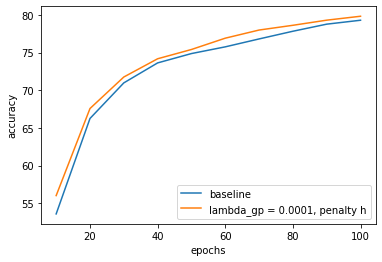

In [14]:
plt.plot([10*i for i in range(1,11)],acc_base, label = 'baseline')
plt.plot([10*i for i in range(1,11)],acc_h_clamp1000, label = 'lambda_gp = 0.0001, penalty h')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [8]:
resnet18_aam_gp_h_0_0001_clamp1000.pth119

NameError: name 'resnet18_aam_gp_h_0_0001_clamp1000' is not defined

In [11]:
grad_sumhlambda0_e50_gpclamp1000_full = cal_grad_h_full(resume = 'resnet18_aam_gp_h_0_001_clamp1000.pth49')

==> Building model..
==> Resuming from checkpoint..

Epoch: 50


Loss: **** ██████████| 98/98 [00:52<00:00,  1.87it/s]


In [12]:
grad_sumhlambda0_e50_gpclamp300_full = cal_grad_h_full(resume = 'resnet18_aam_gp_h_0_01_clamp300.pth49')

==> Building model..
==> Resuming from checkpoint..

Epoch: 50


Loss: **** ██████████| 98/98 [00:52<00:00,  1.86it/s]


In [8]:
grad_sumhlambda0_e50_gp_0_0001_clamp1000_full = cal_grad_h_full(resume = 'resnet18_aam_gp_h_0_0001_clamp1000.pth49')

==> Building model..
==> Resuming from checkpoint..

Epoch: 50


Loss: **** ██████████| 98/98 [00:56<00:00,  1.74it/s]


Text(0.5, 1.0, 'norm 1 of gradient h')

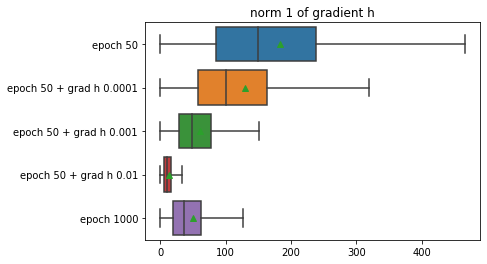

In [17]:
d = {'epoch 50': (grad_sumhlambda0_e50_full+1e-16).norm(p=1, dim = 1).detach(), 
     'epoch 50 + grad h 0.0001': (grad_sumhlambda0_e50_gp_0_0001_clamp1000_full+1e-16).norm(p=1, dim = 1).detach(),
     'epoch 50 + grad h 0.001': (grad_sumhlambda0_e50_gpclamp1000_full+1e-16).norm(p=1, dim = 1).detach(),
     'epoch 50 + grad h 0.01': (grad_sumhlambda0_e50_gpclamp300_full+1e-16).norm(p=1, dim = 1).detach(),
     'epoch 1000': (grad_sumhlambda0_e1000_full+1e-16).norm(p=1, dim = 1).detach()}
df = pd.DataFrame(data=d)
sns.boxplot(data = df, orient = 'h',  showmeans = True,showfliers = False)
plt.title('norm 1 of gradient h')

Text(0.5, 1.0, 'norm 1 of gradient h')

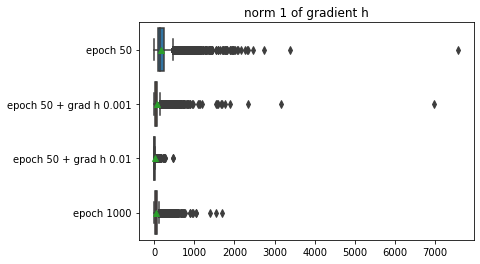

In [42]:
d = {'epoch 50': (grad_sumhlambda0_e50_full+1e-16).norm(p=1, dim = 1).detach(), 
     'epoch 50 + grad h 0.001': (grad_sumhlambda0_e50_gpclamp1000_full+1e-16).norm(p=1, dim = 1).detach(),
     'epoch 50 + grad h 0.01': (grad_sumhlambda0_e50_gpclamp300_full+1e-16).norm(p=1, dim = 1).detach(),
     'epoch 1000': (grad_sumhlambda0_e1000_full+1e-16).norm(p=1, dim = 1).detach()}
df = pd.DataFrame(data=d)
sns.boxplot(data = df, orient = 'h',  showmeans = True,showfliers = True)
plt.title('norm 1 of gradient h')

In [10]:
def cal_grad_h_norm_full(resume):
    # config
    ### config ####
    gradient_lambda_list = []
    representation_list = []

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    base_lr = 0.25
    arch = 'resnet18'
    momentum = 0.9
    cosine_anneal = True
    num_epochs = 1
    test_freq = 1
    lr = base_lr * (batch_size / 256)
    
    best_acc = 0  # best test accuracy
    start_epoch = 0  # start from epoch 0 or last checkpoint epoch
    last_epoch = num_epochs #last epoch or from last epoch from checkpoint 
    clf = None
    current_checkpoint = {}
    acc = 0
    # Model
    print('==> Building model..')
    ##############################################################
    # Encoder
    ##############################################################
    if arch == 'resnet18':
        net = ResNet18(stem=stem)
    elif arch == 'resnet34':
        net = ResNet34(stem=stem)
    elif arch == 'resnet50':
        net = ResNet50(stem=stem)
    else:
        raise ValueError("Bad architecture specification")
    net = net.to(device)

    ##############################################################
    # Critic
    ##############################################################
    critic = LinearCritic(net.representation_dim, temperature=temperature).to(device)

    ###### Differentiable augmentation ######
    brightness_bound = [0.2, 1.8]
    contrast_bound = [0.2, 1.8]
    saturation_bound = [0.2, 1.8]
    hue_bound = [-0.2, 0.2]

    if device == 'cuda':
        repr_dim = net.representation_dim
        net = torch.nn.DataParallel(net)
        net.representation_dim = repr_dim
        cudnn.benchmark = True

    criterion = nn.CrossEntropyLoss()
    base_optimizer = optim.SGD(list(net.parameters()) + list(critic.parameters()), lr=lr, weight_decay=1e-6,
                               momentum=momentum)
    if cosine_anneal == True:
        scheduler = CosineAnnealingWithLinearRampLR(base_optimizer, num_epochs)
    encoder_optimizer = LARS(base_optimizer, trust_coef=1e-3)

    #Resume
    if resume:
        # Load checkpoint.
        print('==> Resuming from checkpoint..')
        assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
        resume_from = os.path.join('./checkpoint', resume)
        checkpoint = torch.load(resume_from)
        net.load_state_dict(checkpoint['net'])
        critic.load_state_dict(checkpoint['critic'])
    #     best_acc = checkpoint['acc']
        start_epoch = checkpoint['epoch'] + 1
        encoder_optimizer.load_state_dict(checkpoint['encoder_optim'])
        base_optimizer.load_state_dict(checkpoint['base_optim'])
        scheduler.step(start_epoch)
        if 'num_epochs' in checkpoint:
            last_epoch = checkpoint['num_epochs']
        else:
            last_epoch = 1000 #default value for num epochs = 1000
        current_checkpoint = checkpoint
        ##### Train #####
        print('\nEpoch: %d' % start_epoch)
#         net.train()
#         critic.train()
        net.eval()
        critic.eval()
        train_loss = 0
        sum_gradient = 0
        train_loss_nogp = 0
        t = tqdm(enumerate(trainloader), desc='Loss: **** ', total=len(trainloader), bar_format='{desc}{bar}{r_bar}')
        for batch_idx, (inputs, _, _) in t:
            x1, x2 = inputs
            x1, x2 = x1.to(device), x2.to(device)

            #colour augmentation
            B = x1.size()[0]
            brightness_list1, saturation_list1, contrast_list1, hue_list1 = gen_lambda(B, brightness_bound,
                                                                                       contrast_bound,
                                                                                       saturation_bound,
                                                                                       hue_bound)
            brightness_list2, saturation_list2, contrast_list2, hue_list2 = gen_lambda(B, brightness_bound,
                                                                                       contrast_bound,
                                                                                       saturation_bound,
                                                                                       hue_bound)
            lambda_ = torch.stack([brightness_list1, saturation_list1, contrast_list1, hue_list1,
                                   brightness_list2, saturation_list2, contrast_list2, hue_list2], dim=1)
            aug_manual1 = DifferentiableColourDistortionByTorch_manual(brightness = lambda_[:,0],
                                                                       contrast = lambda_[:,1],
                                                                       saturation = lambda_[:,2],
                                                                       hue = lambda_[:,3])
            aug_manual2 = DifferentiableColourDistortionByTorch_manual(brightness = lambda_[:,4],
                                                                       contrast = lambda_[:,5],
                                                                       saturation = lambda_[:,6],
                                                                       hue = lambda_[:,7])

            x1, x2 = aug_manual1(x1), aug_manual2(x2)
            x1, x2 = ManualNormalise(x1, dataset), ManualNormalise(x2, dataset)

            encoder_optimizer.zero_grad()
            representation1, representation2 = net(x1), net(x2)
            
            # gradient penalty
            sum_rep1 = representation1.sum()
            sum_rep2 = representation2.sum()
            sum_rep = sum_rep1 + sum_rep2
            sum_rep = sum_rep/sum_rep.norm(p=2, dim = -1, keepdim = True)
            
            gradient_lambda =  autograd.grad(outputs = sum_rep,
                                 inputs = lambda_,
                                 create_graph = False,
                                 retain_graph = False,
                                 only_inputs = True)[0]
            
            gradient_lambda_list.append(gradient_lambda)
            
    return torch.cat(gradient_lambda_list, dim = 0)

In [11]:
grad_sumh_norm_lambda0_e100_full = cal_grad_h_norm_full(resume = 'resnet18_aam_new_baseline_rerun.pth99')

==> Building model..
==> Resuming from checkpoint..

Epoch: 100


Loss: **** ██████████| 98/98 [00:55<00:00,  1.77it/s]


In [12]:
grad_sumh_norm_lambda0_e1000_full = cal_grad_h_norm_full(resume = 'resnet18_aam_new_baseline_rerun.pth999')

==> Building model..
==> Resuming from checkpoint..

Epoch: 1000


Loss: **** ██████████| 98/98 [00:51<00:00,  1.92it/s]


In [15]:
grad_sumh_norm_lambda0_e50_full = cal_grad_h_norm_full(resume = 'resnet18_aam_new_baseline_rerun.pth49')

==> Building model..
==> Resuming from checkpoint..

Epoch: 50


Loss: **** ██████████| 98/98 [00:51<00:00,  1.90it/s]


In [16]:
grad_sumh_norm_lambda0_0001_gradh_e50_full = cal_grad_h_norm_full(resume = 'resnet18_aam_gp_h_0_0001_clamp1000.pth49')

==> Building model..
==> Resuming from checkpoint..

Epoch: 50


Loss: **** ██████████| 98/98 [00:51<00:00,  1.89it/s]


In [17]:
grad_sumh_norm_lambda0_0001_gradh_norm_e50_full = cal_grad_h_norm_full(resume = 'resnet18_aam_gp_h_0_01_clamp1000_norm.pth49')

==> Building model..
==> Resuming from checkpoint..

Epoch: 50


Loss: **** ██████████| 98/98 [00:51<00:00,  1.89it/s]


In [13]:
grad_sumh_norm_lambda0_e1000_full.size()

torch.Size([50000, 8])

Text(0.5, 1.0, 'norm 1 of gradient norm h')

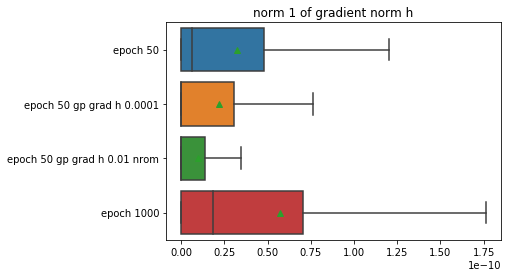

In [18]:
d = {'epoch 50': (grad_sumh_norm_lambda0_e50_full+1e-16).norm(p=1, dim = 1).detach(), 
     'epoch 50 gp grad h 0.0001': (grad_sumh_norm_lambda0_0001_gradh_e50_full+1e-16).norm(p=1, dim = 1).detach(),
     'epoch 50 gp grad h 0.01 nrom': (grad_sumh_norm_lambda0_0001_gradh_norm_e50_full+1e-16).norm(p=1, dim = 1).detach(),
     'epoch 1000': (grad_sumh_norm_lambda0_e1000_full+1e-16).norm(p=1, dim = 1).detach()}
df = pd.DataFrame(data=d)
sns.boxplot(data = df, orient = 'h',  showmeans = True,showfliers = False)
plt.title('norm 1 of gradient norm h')

# result from norm h

In [7]:
my_resume_from = os.path.join('./checkpoint', 'resnet18_aam_gp_h_0_01_clamp1000_norm.pth49')
my_checkpoint_h_norm_0_01 = torch.load(my_resume_from)
my_checkpoint_h_norm_0_01['test_acc']


[55.25, 66.49, 71.61, 74.09, 75.67]

In [9]:
my_resume_from = os.path.join('./checkpoint', 'resnet18_aam_gp_h_0_0001_clamp1000.pth99')
my_checkpoint_h_clamp1000 = torch.load(my_resume_from)
acc_h_clamp1000 = my_checkpoint_h_clamp1000['test_acc']
print(acc_h_clamp1000)

[56.02, 67.57, 71.75, 74.17, 75.4, 76.9, 77.98, 78.61, 79.29, 79.81]


In [8]:
my_resume_from = os.path.join('./checkpoint', 'resnet18_aam_baseline2.pth99')
my_checkpoint = torch.load(my_resume_from)
acc_base = my_checkpoint['test_acc']
print(acc_base)

[53.59, 66.25, 70.97, 73.62, 74.86, 75.75, 76.8, 77.82, 78.76, 79.28]
